# V2X 데이터 정보

In [2]:
import numpy as np
import cv2
import torch
import pandas as pd
import re
import pickle as pkl
import json
import glob
import shutil
import os
import json
import pathlib as pl
from typing import List, Tuple, Dict, Union, Optional
from tqdm import trange, tqdm
from glob import glob
from collections import Counter
from sklearn.model_selection import train_test_split

from preprocessing import V2XPreprocessing
from modules.v2x import V2XData,V2XDataLabeled
from modules.metrics import *
from tsai.all import *
from tqdm import tqdm
from modules.RunTSAI import RunTSAI
from sklearn.utils import shuffle


data_path_8 = "/data/NIA50/50-1/data/v2xfinal/8월"
data_path_8s = "/data/NIA50/50-1/data/v2xfinal/8월세종"
data_path_9 = "/data/NIA50/50-1/data/v2xfinal/9월"
data_path_10 = "/data/NIA50/50-1/data/v2xfinal/10월"
data_path_11 = "/data/NIA50/50-1/data/v2xfinal/11월"

ModuleNotFoundError: No module named 'preprocessing'

## CSV, JSON 파일 경로 리스트 만들기
- CSV, JSON 파일을 한 경로에 담기
  - 8월
  -  ㄴ CSV
  -  ㄴ JSON
  - 9월
  -  ㄴ CSV
  -  ㄴ JSON

In [2]:
# 9월csv파일과 json파일을 각각 리스트로 가져옴
csv_files9, json_files9 = V2XPreprocessing.get_csv_data(data_path_9 + "/CSV"), \
                            V2XPreprocessing.get_json_data(data_path_9 + "/JSON")
print(f"csv file count: {len(csv_files9)}, json file count: {len(json_files9)}")

csv file count: 1350000, json file count: 1350000


In [3]:
# csv파일과 json파일 리스트를 pickle로 저장
with open("pickles/9월/CSV9.pkl", "wb") as f:
    pkl.dump(csv_files9, f)
with open("pickles/9월/JSON9.pkl", "wb") as f:
    pkl.dump(json_files9, f)

In [3]:
# csv파일과 json파일 각 리스트를 pickle로 가져옴
with open("pickles/9월/CSV9.pkl", "rb") as f:
    csv_files9 = pkl.load(f)
with open("pickles/9월/JSON9.pkl", "rb") as f:
    json_files9 = pkl.load(f)

In [4]:
# CSV파일 concat, pickle로 저장
df9csv = [pd.read_csv(f) for f in tqdm(csv_files9, desc="Reading csv files")]
df9csv = pd.concat(df9csv, ignore_index=True)
with open("pickles/9월/df9csv.pkl", "wb") as f:
    pkl.dump(df9csv, f)

Reading csv files: 100%|██████████| 1350000/1350000 [1:05:52<00:00, 341.55it/s]


In [6]:
# CSV파일 concat pickle로 가져옴
with open("pickles/9월/df9csv.pkl", "rb") as f:
    df9csv = pkl.load(f)

In [7]:
df9csv.head()

,ISSUE_DATE,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,20220901133250,FFE809A1,9228,126.912622,35.155949,21,25,0,56,bus
1,20220901133251,FFE809A1,9228,126.912654,35.156013,21,28,0,56,bus
2,20220901133252,FFE809A1,9228,126.912685,35.156084,18,31,0,83,bus
3,20220901133253,FFE809A1,9228,126.912717,35.156163,18,32,0,28,bus
4,20220901133254,FFE809A1,9228,126.912748,35.156244,18,33,0,28,bus


In [8]:
# NaN값 제거 후 NaN값이 있는지 확인
df9csv = df9csv.dropna()
# counts rows if there's NaN value
df9csv.isna().sum()

ISSUE_DATE       0
VEHICLE_ID       0
VEHICLE_CLASS    0
LONGITUDE        0
LATITUDE         0
HEADING          0
SPEED            0
BRAKE_STATUS     0
ACC_SEC          0
VEHICLE_TYPE     0
dtype: int64

In [9]:
df9csv.shape

(13500000, 10)

In [10]:
# int or float type이 아닌 값이 있는지 확인
for col in df9csv.columns:
    if col in ["VEHICLE_ID", "VEHICLE_TYPE"]:
        continue
    # print if value is not float or int
    print(f"{col}: {df9csv[col].apply(lambda x: type(x) not in [float, int]).sum()}")

ISSUE_DATE: 0
VEHICLE_CLASS: 0
LONGITUDE: 0
LATITUDE: 0
HEADING: 0
SPEED: 0
BRAKE_STATUS: 0
ACC_SEC: 0


In [11]:
# exclude ["ISSUE_DATE"] column, values to int on ["VEHICLE_CLASS", "HEADING"], str on ["VEHICLE_ID", "VEHICLE_TYPE"], float on others

for col in df9csv.columns:
    if col in ["ISSUE_DATE"]:
        df9csv.drop(col, axis=1, inplace=True)
    elif col in ["VEHICLE_CLASS", "HEADING"]:
        df9csv[col] = df9csv[col].astype(int)
    elif col in ["VEHICLE_ID", "VEHICLE_TYPE"]:
        df9csv[col] = df9csv[col].astype(str)
    else:
        df9csv[col] = df9csv[col].astype(float)

In [12]:
# value counts of VEHICLE_ID VEHICLE_CLASS VEHICLE_TYPE
for col in df9csv.columns:
    if col in ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"]:
        print(f"{col}: {df9csv[col].value_counts()}")
        print(f"{col} unique: {df9csv[col].unique().shape}", end="\n\n")

VEHICLE_ID: FFE80C05    18800
FFE80D2A    18600
FFE80CBE    18200
FFE80D14    17600
FFE80D4B    17600
            ...  
FFE80CB2      200
FFE80E5B      200
70CE0D36      200
FFE80FD1      200
FFE81127      200
Name: VEHICLE_ID, Length: 1689, dtype: int64
VEHICLE_ID unique: (1689,)

VEHICLE_CLASS: 9228    10006383
9220     3099277
9736      159340
9230       98200
9741       97200
9240       28400
9734       11000
9227         200
Name: VEHICLE_CLASS, dtype: int64
VEHICLE_CLASS unique: (8,)

VEHICLE_TYPE: bus         10005566
car          3098919
special       394091
none            1224
axleCnt2         200
Name: VEHICLE_TYPE, dtype: int64
VEHICLE_TYPE unique: (5,)



In [13]:
# categorize ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"] columns
from sklearn.preprocessing import LabelEncoder

for col in df9csv.columns:
    if col in ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"]:
        encoder = LabelEncoder()
        encoder.fit(df9csv[col])
        categorized_array = encoder.transform(df9csv[col])
        print(categorized_array)
        df9csv[col] = categorized_array

[   6    6    6 ... 1677 1677 1677]
[2 2 2 ... 2 2 2]
[1 1 1 ... 1 1 1]


In [14]:
# index reset
df9csv.reset_index(drop=True, inplace=True)
df9csv

,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,6,2,126.912622,35.155949,21,25.0,0.0,56.0,1
1,6,2,126.912654,35.156013,21,28.0,0.0,56.0,1
2,6,2,126.912685,35.156084,18,31.0,0.0,83.0,1
3,6,2,126.912717,35.156163,18,32.0,0.0,28.0,1
4,6,2,126.912748,35.156244,18,33.0,0.0,28.0,1
...,...,...,...,...,...,...,...,...,...
13499995,1677,2,126.786182,35.127261,163,29.0,0.0,0.0,1
13499996,1677,2,126.786210,35.127190,161,29.0,0.0,-28.0,1
13499997,1677,2,126.786236,35.127119,162,29.0,0.0,0.0,1
13499998,1677,2,126.786263,35.127051,162,28.0,0.0,0.0,1


# Standarization

In [15]:
# standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df9csv_scaled = scaler.fit_transform(df9csv)
df9csv_scaled = pd.DataFrame(df9csv_scaled, columns=df9csv.columns)
df9csv_scaled

,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,-1.564226,0.333399,0.044779,-0.017130,-1.338208,0.448211,-0.913881,1.130941,-0.506789
1,-1.564226,0.333399,0.044807,-0.016916,-1.338208,0.599930,-0.913881,1.130941,-0.506789
2,-1.564226,0.333399,0.044835,-0.016678,-1.365698,0.751648,-0.913881,1.677418,-0.506789
3,-1.564226,0.333399,0.044863,-0.016415,-1.365698,0.802221,-0.913881,0.564224,-0.506789
4,-1.564226,0.333399,0.044891,-0.016146,-1.365698,0.852794,-0.913881,0.564224,-0.506789
...,...,...,...,...,...,...,...,...,...
13499995,2.072355,0.333399,-0.067610,-0.112597,-0.037047,0.650502,-0.913881,-0.002493,-0.506789
13499996,2.072355,0.333399,-0.067585,-0.112834,-0.055373,0.650502,-0.913881,-0.569210,-0.506789
13499997,2.072355,0.333399,-0.067562,-0.113069,-0.046210,0.650502,-0.913881,-0.002493,-0.506789
13499998,2.072355,0.333399,-0.067538,-0.113299,-0.046210,0.599930,-0.913881,-0.002493,-0.506789


# CSV 파일 Dataframe pickle로 저장

In [16]:
with open("pickles/9월/df9_scaled.pkl", "wb") as f:
    pkl.dump(df9csv_scaled, f)

In [18]:
df9csv_scaled = pd.read_pickle("pickles/9월/df9_scaled.pkl") # load pickle

In [27]:
# reshape 1350000 rows × 9 columns to 1350000 rows x 9 columns x 10, and changed to numpy array
df9csv_scaled_npy = df9csv_scaled.values.reshape(df9csv_scaled.shape[0]//10, 10, 9)
df9csv_scaled_npy = df9csv_scaled_npy.transpose(0, 2, 1)

In [28]:
# save numpy array as npy file
np.save("pickles/9월/X_9.npy", df9csv_scaled_npy)

In [29]:
print(df9csv_scaled_npy.shape)
df9csv_scaled_npy[:2]

(13500000, 9)


,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,-1.564226,0.333399,0.044779,-0.017130,-1.338208,0.448211,-0.913881,1.130941,-0.506789
1,-1.564226,0.333399,0.044807,-0.016916,-1.338208,0.599930,-0.913881,1.130941,-0.506789


----------------------

# JSON

In [3]:
with open("pickles/9월/JSON9.pkl", "rb") as f:
    json_files9 = pkl.load(f)

In [4]:
# json info
with open(json_files9[0], "r") as f:
    json_sample = json.load(f)
json_sample

{'Path': 'V_220901_C_A_FFE809A1_000107.csv',
 'Annotation': {'Vehicle_ID': 'FFE809A1',
  'Turn': 'False',
  'Lane': 'False',
  'Speed': 'False',
  'Hazard': 'False'}}

In [59]:
df9_json = pd.read_json(json_files9[0])
# df8_json = df8_json['Annotation'][['Turn', 'Lane', 'Speed', 'Hazard']].to_frame().T
# values = df8_json.values.tolist()[0]
# values
df9_json

,Path,Annotation
Hazard,V_220801_C_A_FFE809B4_000075.csv,False
Lane,V_220801_C_A_FFE809B4_000075.csv,False
Speed,V_220801_C_A_FFE809B4_000075.csv,False
Turn,V_220801_C_A_FFE809B4_000075.csv,False
Vehicle_ID,V_220801_C_A_FFE809B4_000075.csv,FFE809B4


In [5]:
json9_list = []
cols = ['Turn', 'Lane', 'Speed', 'Hazard']
print(cols)

df8json = pd.DataFrame(columns=cols)
for i in trange(len(json_files9)):
    with open(json_files9[i], "r") as f:
        temp_json = json.load(f)
        temp_json = [temp_json['Annotation'][key] for key in temp_json['Annotation'].keys() if key in cols]
        json9_list.append(temp_json)
        
# json8_list = [x[:4] for x in json8_list]
json9_npy = np.array(json9_list)

['Turn', 'Lane', 'Speed', 'Hazard']


100%|██████████| 1350000/1350000 [32:48<00:00, 685.82it/s] 


In [6]:
np.save("pickles/9월/y_9.npy", json9_npy)

In [7]:
json9_npy = np.load("pickles/9월/y_9.npy")
json9_npy.shape

(1350000, 4)

In [8]:
json9_npy

array([['False', 'False', 'False', 'False'],
       ['False', 'False', 'False', 'False'],
       ['False', 'False', 'False', 'False'],
       ...,
       ['False', 'False', 'False', 'False'],
       ['False', 'False', 'False', 'False'],
       ['False', 'False', 'False', 'False']], dtype='<U7')

-------------------------------------------

# Time series classification

In [5]:
X = np.load("pickles/9월/X_9.npy")
y = np.load("pickles/9월/y_9.npy")

###
from collections import Counter
print("turn:", np.unique(y[:, 0]))
print("lane:", np.unique(y[:, 1]))
print("speed:", np.unique(y[:, 2]))
print("hazard:", np.unique(y[:, 3]))
print("turn:", Counter(y[:, 0]))
print("lane:", Counter(y[:, 1]))
print("speed:", Counter(y[:, 2]))
print("hazard:", Counter(y[:, 3]))
print(f"X shape: {X.shape}, y shape: {y.shape}")

turn: ['Fals' 'Left' 'Reve' 'Righ']
lane: ['Fals']
speed: ['Acc' 'Fals' 'Hbrk']
hazard: ['Fals' 'True']
turn: Counter({'Fals': 1274127, 'Righ': 38008, 'Left': 35376, 'Reve': 2489})
lane: Counter({'Fals': 1350000})
speed: Counter({'Fals': 1348923, 'Hbrk': 796, 'Acc': 281})
hazard: Counter({'Fals': 1345730, 'True': 4270})
X shape: (1350000, 9, 10), y shape: (1350000, 4)


In [8]:
y[:10000]

array([['Fals', 'Fals', 'Fals', 'Fals'],
       ['Fals', 'Fals', 'Fals', 'Fals'],
       ['Fals', 'Fals', 'Fals', 'Fals'],
       ...,
       ['Fals', 'Fals', 'Fals', 'Fals'],
       ['Righ', 'Fals', 'Fals', 'Fals'],
       ['Left', 'Fals', 'Fals', 'Fals']], dtype='<U4')

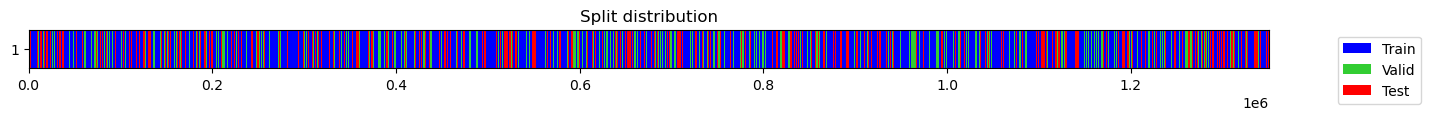

In [9]:
from tsai.all import *
config = AttrDict(
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = LSTM, # LSTM, MLSTM_Plus
    lr = 1e-3,
    n_epochs = 200,
)

X = np.load("pickles/9월/X_9.npy")
y = np.load("pickles/9월/y_9.npy")
split_all = get_splits(y[:,0], shuffle=True, valid_size=0.2, test_size=0.2, random_state=42)
split = split_all

In [10]:
test_eq(X.shape, (X.shape[0], 9, 10))
test_eq(y.shape, (X.shape[0], 4))

epoch,train_loss,valid_loss,accuracy_multi,precision_multi,F1_multi,time
0,0.010428,0.010624,0.996796,0.991030,0.989436,04:26
1,0.008913,0.009134,0.997445,0.994053,0.991566,04:25
2,0.007787,0.008153,0.997876,0.995877,0.992974,04:27
3,0.007173,0.007528,0.998090,0.996491,0.993681,04:26
4,0.006672,0.007178,0.998199,0.996708,0.994043,04:24
5,0.006257,0.006813,0.998321,0.996913,0.994447,04:26
6,0.005976,0.006542,0.998431,0.997290,0.994808,04:22
7,0.005481,0.006429,0.998478,0.997429,0.994959,04:27
8,0.005022,0.006165,0.998599,0.997872,0.995361,04:24
9,0.004973,0.006085,0.998597,0.997554,0.995357,04:24


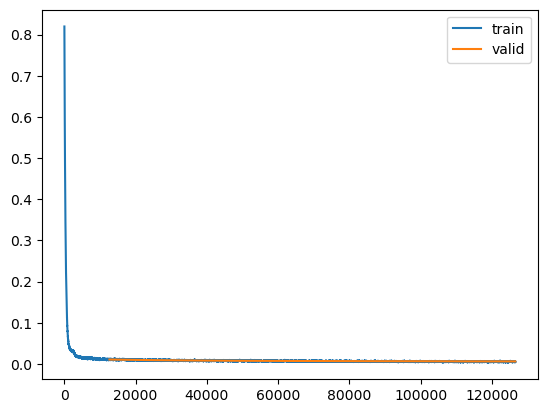

In [12]:
tfms = [None, [MultiCategorize, OneHotEncode]]
dsets = TSDatasets(X, y, tfms=tfms, splits=split)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], shuffle_train=False, batch_tfms=[TSStandardize()])

model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=[accuracy_multi, precision_multi, F1_multi])
learn.fit_one_cycle(10)
learn.recorder.plot_loss()

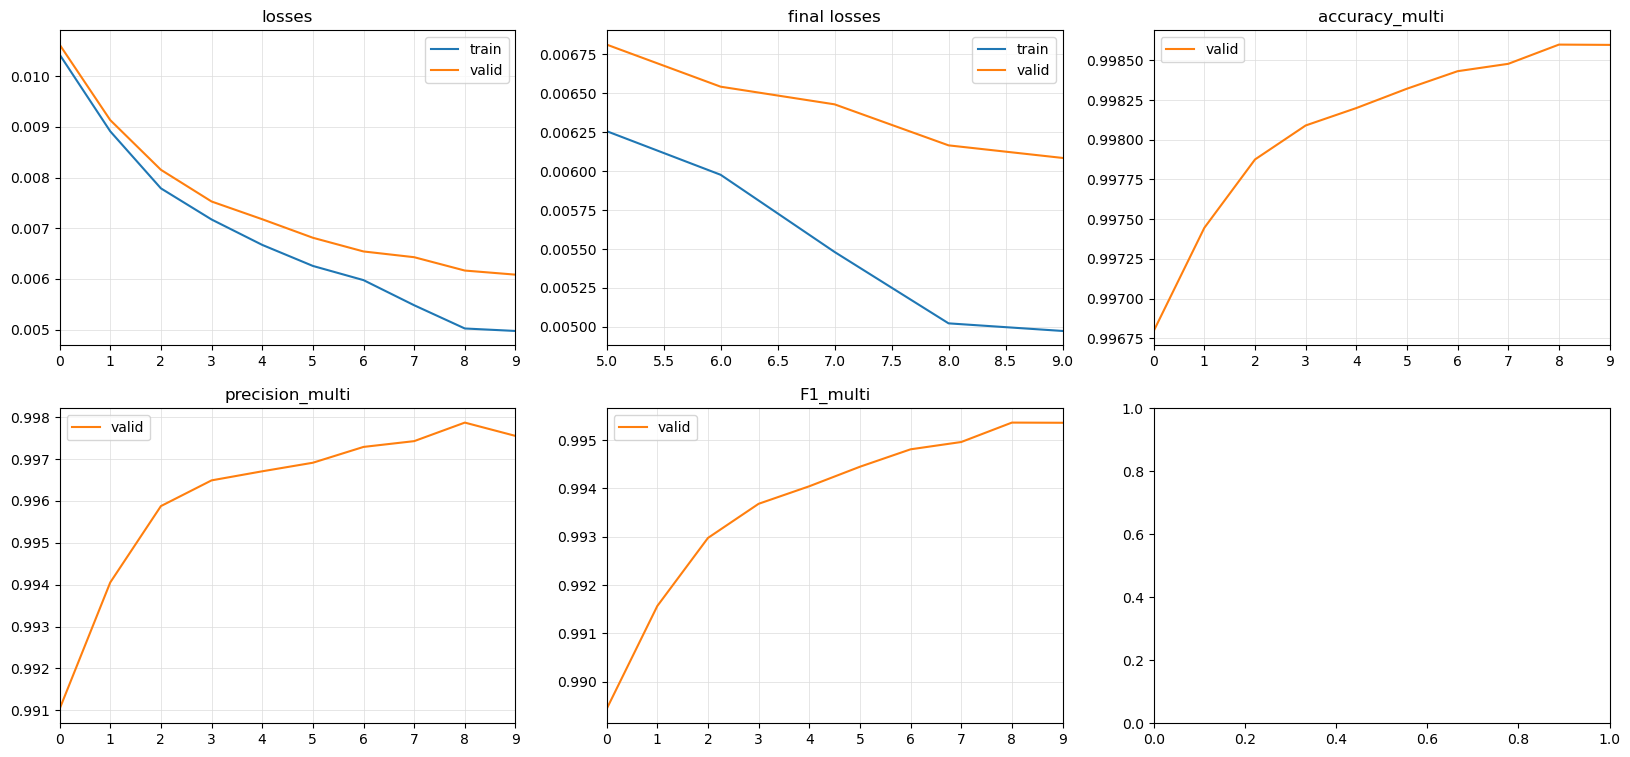

In [13]:
learn.recorder.plot_metrics()
learn.save_all("models/V2X_9")

-------------------

# Load model, get prediction

In [ ]:
learn = load_learner_all(path="V2X_9", dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
dls_valid = dls.valid
test_probas, test_targets, test_preds = learn.get_preds(dl=dls_valid, with_decoded=True)

In [ ]:
print(test_probas[0])
print(test_targets[0])
print(test_preds[0])

In [ ]:
# check test_targets[0] if it has two 1s
for att in test_targets:
    if np.count_nonzero(att) > 1:
        print(att, np.count_nonzero(att))